In [1]:
%matplotlib inline

import numpy as np
import csv
import pandas as pd
import tempfile
import math
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
import tensorflow as tf
import tensorflow.contrib.learn.python.learn as learn
from sklearn import datasets, metrics, preprocessing
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_users = pd.read_csv("/Users/ozimmer/Google Drive/berkeley/w207/final project/Group_Project/train_users_2.csv")
test_users = pd.read_csv("/Users/ozimmer/Google Drive/berkeley/w207/final project/Group_Project/test_users.csv")
test_id = test_users['id']

## Feature engineering

In [3]:
df_train = train_users
df_test = test_users

# concatenate the train and test user files
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

# split date fields into 3 columns (year, month, day) to avoid having a feature for every possible date
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['acct_create_year'] = dac[:,0]
df_all['acct_create_month'] = dac[:,1]
df_all['acct_create_day'] = dac[:,2]

# concat account create month/year
df_all['acct_create_month_year'] = df_all.acct_create_month.astype(str) +'/'+ df_all.acct_create_year.astype(str)

# drop columns unecessary for prediction
df_all = df_all.drop(['id', 'date_first_booking','date_account_created','timestamp_first_active','acct_create_day','acct_create_month','acct_create_year'], axis=1)

#set unknown gender values to NA
df_all.gender = df_all.gender.replace('-unknown-',np.nan)

#fill NA values with -1
df_all = df_all.fillna("NaN")

# The age field is populated with some outlying values and some year values (e.g., 2014)
# This will pull only ages between 14 and 100
av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<14, av>100), 0, av)

#################################################### 
##### @CHRIS, this is the feature that I removed
####################################################
# encode categorical features with dummy values
# categorical = ['acct_create_month_year', 'age', 'gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
# for f in categorical:
#     df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
#     df_all = df_all.drop([f], axis=1)
#     df_all = pd.concat((df_all, df_all_dummy), axis=1)

#Encode label in integer for TensorFlow
le = preprocessing.LabelEncoder()
le.fit(df_all["country_destination"])
df_all["label"] = le.transform(df_all["country_destination"])

In [4]:
# After cleansing, split the data back up between the train and test users
length_training_set = train_users.shape[0]
train_values = df_all[:length_training_set] 
test_data = df_all[length_training_set:]

# Split training values between train & dev sets 
np.random.seed(0)
msk = np.random.rand(len(train_values)) < 0.75
train_data = train_values[msk]
dev_data = train_values[~msk]

## Linear classifier using TensorFlow

In [5]:
#Continuous variables are converted into a Tensor while Categorical variables are converted into a SparseTensor
CATEGORICAL_COLUMNS = ["gender", "signup_method", "language", "affiliate_channel", "affiliate_provider", "first_affiliate_tracked",
                        "signup_app", "first_device_type", "first_browser", "acct_create_month_year"]

CONTINUOUS_COLUMNS = ["age", "signup_flow"]

LABEL_COLUMN = "label" 

def input_fn(df):
    # Creates a dictionary mapping from each continuous feature column name (k) to
    # the values of that column stored in a constant Tensor.
    continuous_cols = {k: tf.constant(df[k].values.astype(int)) for k in CONTINUOUS_COLUMNS}
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(df[k].size)],
                                           values=df[k].values,
                                           shape=[df[k].size, 1])
                        for k in CATEGORICAL_COLUMNS}
    # Merges the two dictionaries into one.
    feature_cols = dict(continuous_cols.items() + categorical_cols.items())
    # Converts the label column into a constant Tensor.
    label = tf.constant(df[LABEL_COLUMN].values)
    # Returns the feature columns and the label.
    return feature_cols, label

def train_input_fn():
    return input_fn(train_data)

def eval_input_fn():
    return input_fn(dev_data)

def test_input_fn():
    return input_fn(test_data)

# Defining FeatureColumns and Creating the Regressor (no data here, just the structure)
gender = tf.contrib.layers.sparse_column_with_hash_bucket("gender", hash_bucket_size=4)
signup_method = tf.contrib.layers.sparse_column_with_hash_bucket("signup_method", hash_bucket_size=3)
language = tf.contrib.layers.sparse_column_with_hash_bucket("language", hash_bucket_size=25)
affiliate_channel = tf.contrib.layers.sparse_column_with_hash_bucket("affiliate_channel", hash_bucket_size=8)
affiliate_provider = tf.contrib.layers.sparse_column_with_hash_bucket("affiliate_provider", hash_bucket_size=18)
first_affiliate_tracked = tf.contrib.layers.sparse_column_with_hash_bucket("first_affiliate_tracked", hash_bucket_size=8)
signup_app = tf.contrib.layers.sparse_column_with_hash_bucket("signup_app", hash_bucket_size=4)
first_device_type = tf.contrib.layers.sparse_column_with_hash_bucket("first_device_type", hash_bucket_size=9)
first_browser = tf.contrib.layers.sparse_column_with_hash_bucket("first_browser", hash_bucket_size=49)
acct_create_month_year = tf.contrib.layers.sparse_column_with_hash_bucket("acct_create_month_year", hash_bucket_size=54)

age = tf.contrib.layers.real_valued_column("age")
signup_flow = tf.contrib.layers.real_valued_column("signup_flow")

#Building the model
model_dir = tempfile.mkdtemp()
m = tf.contrib.learn.LinearClassifier(feature_columns=[gender, signup_method, language, 
                                                        affiliate_channel, affiliate_provider, 
                                                        first_affiliate_tracked, signup_app, first_device_type, 
                                                        first_browser, acct_create_month_year, age, signup_flow],
                                      n_classes= 13, 
                                      model_dir=model_dir)

#Fit - calling now for the data
m.fit(input_fn = eval_input_fn, steps = 200)

results = m.evaluate(input_fn = eval_input_fn, steps=1)
for key in sorted(results):
     print "%s: %s" % (key, results[key])

y = m.predict_proba(input_fn = test_input_fn)

user_ids = []  #list of ids
countries = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    user_ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(y[i])[::-1])[:5].tolist()
sub = pd.DataFrame(np.column_stack((user_ids, countries)), columns=['id', 'country'])
sub.to_csv('sub_LinearClassifier.csv',index=False)

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.


accuracy: 0.605187
global_step: 200
loss: 1.10624


## DNN model using Tensorflow

In [6]:
deep_columns = [
tf.contrib.layers.embedding_column(gender, dimension=4),
tf.contrib.layers.embedding_column(signup_method, dimension=3),
tf.contrib.layers.embedding_column(language, dimension=20), #25
tf.contrib.layers.embedding_column(affiliate_channel, dimension=8),
tf.contrib.layers.embedding_column(affiliate_provider, dimension=8), #18
tf.contrib.layers.embedding_column(first_affiliate_tracked, dimension=8),
tf.contrib.layers.embedding_column(signup_app, dimension=4),
tf.contrib.layers.embedding_column(first_device_type, dimension=8), #9
tf.contrib.layers.embedding_column(first_browser, dimension=20), #49
tf.contrib.layers.embedding_column(acct_create_month_year, dimension=20), #54
age,
signup_flow
]

model_dir = tempfile.mkdtemp()
dnn = tf.contrib.learn.DNNLinearCombinedClassifier(
    model_dir = model_dir,
    dnn_feature_columns=deep_columns,
    dnn_hidden_units=[10, 20, 10],
    n_classes= 13)

dnn.fit(input_fn = train_input_fn, steps = 500)

# results = dnn.evaluate(input_fn = train_input_fn, steps=1)
# for key in sorted(results):
#      print "%s: %s" % (key, results[key])

results = dnn.evaluate(input_fn = eval_input_fn, steps=1)
for key in sorted(results):
     print "%s: %s" % (key, results[key])
        
ydnn = dnn.predict_proba(input_fn = test_input_fn)

user_ids = []  #list of ids
countries = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    user_ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(ydnn[i])[::-1])[:5].tolist()
sub = pd.DataFrame(np.column_stack((user_ids, countries)), columns=['id', 'country'])
sub.to_csv('sub_DNNLinearCombinedClassifier.csv',index=False)

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.


accuracy: 0.628756
global_step: 500
loss: 1.08494


## Looping through parameters
### a. Steps

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


  step 1 : 0.629


  step 10 : 0.629


  step 50 : 0.629


  step 100 : 0.630


  step 500 : 0.632


  step 1000 : 0.632


  step 2000 : 0.633


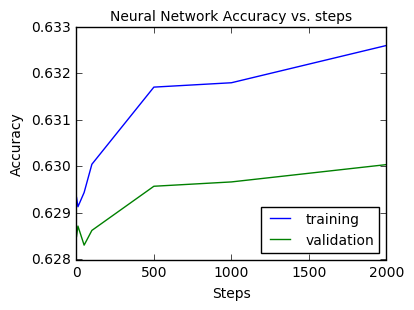

In [7]:
STEPS = [1, 10, 50, 100, 500, 1000, 2000] 
HIDDEN_UNITS = [10, 20, 10]
periods = 5

dnn_learning_steps = tf.contrib.learn.DNNLinearCombinedClassifier(
    model_dir = model_dir,
    dnn_feature_columns = deep_columns,
    dnn_hidden_units = HIDDEN_UNITS,
    n_classes= 13)

accuracy_trainings = []
accuracy_validations = []
for step in STEPS:
    dnn_learning_steps.fit(
    input_fn = train_input_fn,
    steps = step
    )
    
    accuracy_training = dnn_learning_steps.evaluate(input_fn = train_input_fn, steps = 1)
    accuracy_validation = dnn_learning_steps.evaluate(input_fn = eval_input_fn, steps = 1)
        
    accuracy_trainings.append(accuracy_training['accuracy'])
    accuracy_validations.append(accuracy_validation['accuracy'])

    #print "  step %i : %3.3f" % (step, accuracy_training['accuracy'])

# Output a graph of loss metrics over periods.
plt.figure(figsize=(4,3))
plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.title("Neural Network Accuracy vs. steps", fontsize= 10)
plt.plot(STEPS, accuracy_trainings, label='training')
plt.plot(STEPS, accuracy_validations, label='validation')
plt.legend(loc = 4, fontsize= 10)
plt.show()

### b. Number of hidden units

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


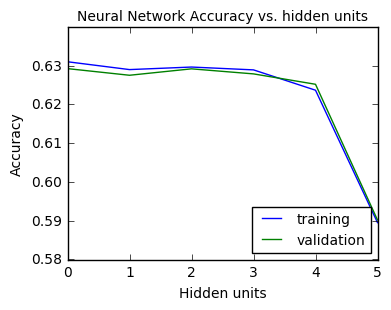

In [22]:
# Loop through hidden units parameter
step = 500
HIDDEN_UNITS = [[10],[10, 10],[10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10, 10], [10, 10, 10, 10, 10, 10]]

def DNN_parameters(step_arg, hidden_unit):

    model_dir = tempfile.mkdtemp()
    dnn_hidden = tf.contrib.learn.DNNLinearCombinedClassifier(
        model_dir = model_dir,
        dnn_feature_columns=deep_columns,
        dnn_hidden_units=hidden_unit,
        n_classes= 13)
    dnn_hidden.fit(input_fn = train_input_fn, steps = step_arg)
    
    accuracy_training = dnn_hidden.evaluate(input_fn = train_input_fn, steps = 1)
    accuracy_validation = dnn_hidden.evaluate(input_fn = eval_input_fn, steps = 1)
    return accuracy_training['accuracy'], accuracy_validation['accuracy']

accuracy_trainings = []
accuracy_validations = []
for hidden_unit in HIDDEN_UNITS:
    accuracies = DNN_parameters(step_arg = 500, hidden_unit = hidden_unit)
    accuracy_trainings.append(accuracies[0])
    accuracy_validations.append(accuracies[1])

# Output a graph of loss metrics over periods.
plt.figure(figsize=(4,3))
plt.ylabel("Accuracy")
plt.xlabel("# of Hidden units")
plt.title("Neural Network Accuracy vs. # of hidden units", fontsize= 10)
plt.plot(accuracy_trainings, label='training')
plt.plot(accuracy_validations, label='validation')
plt.legend(loc = 4, fontsize= 10)
plt.show()
